In [1]:
#import necessary libraries

import torch
import numpy
import pandas
from torch.utils import data
import matplotlib.pyplot as plt
 
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.nn import init
from torch.nn import Module
import torch.nn.functional as F
import math

 
from torch import nn

#JULIA

# # Set display width, load packages, import symbols
# ENV["COLUMNS"]=72
# using Pkg
# # Check installed packages and install uninstalled ones
# isinstalled(pkg::String) = any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
# pk = ["Knet","Statistics","IterTools", "MLDatasets", "Plots","CUDA"]
# using Pkg;
# for p in pk
#     if isinstalled(p)==false
#         println("Installing ", p)
#         Pkg.add(p)
#     else
#         println("Found ", p)
#     end
# end
# # for p in pk; isinstalled(p) || Pkg.add(p); end


# using Base.Iterators: flatten
# using IterTools: ncycle, takenth
# using Statistics: mean
# using MLDatasets: MNIST
# import CUDA # functional
# import Knet # load, save
# using Knet: conv4, pool, mat, KnetArray, nll, accuracy, progress, sgd, param, param0, training, dropout, relu, minibatch, Data

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Some libraries for a data to load from
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

transform = transforms.Compose([ # Transoforms the data to Tensor
    transforms.ToTensor()
])

# Load MNIST Dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform) # Train = True means Training Set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # Train = False means Test Set
print(len(mnist_trainset)) # Size of mnist trainset is 60000
print(len(mnist_testset)) # Size of mnist testset is 10000

# Assigning Some Values Beforehand

batch_size = 100
n_iters = 3000
input_dim = 784
output_dim = 10
lr_rate = 0.1

# Construct minibatches from train_dataloaders and test_dataloader = [ (x1,y1), (x2,y2), ... ] 
# (xi,yi) are minibatch pairs of size 100 samples each
# Each sample in a minibatch pair (xi,yi) is of size 784 and 1 for x and y
from torch.utils.data import DataLoader, Subset
train_dataloaders = DataLoader(mnist_trainset, # MNIST trainset
                                batch_size=batch_size, # 100 batches
                                shuffle=True, # Shuffle the batches
                                drop_last=False # Dont drop the last batch
                     )

print(len(train_dataloaders)) # Length will be 600 because there are 600 batches

test_dataloader  = DataLoader(mnist_testset, # MNIST testset
                              batch_size=batch_size, # 100 batches
                              shuffle=False)

print(len(test_dataloader)) # Length will be 100 because there are 100 batches

dataiter = iter(train_dataloaders) # iterating the trainset batches
(train_features, train_labels) = next(dataiter) # Take the first minibatch
print(train_features.shape) # features of one minibatch will have the 4D size of [100, 1, 28, 28]

print(train_labels.shape) # # labels of one minibatch will have the size of [100]

#JULIA

# # Load MNIST data
# xtrn,ytrn = MNIST.traindata(Float32); # Training Set
# ytrn[ytrn.==0] .= 10 # Change label 0 to 10
# xtst,ytst = MNIST.testdata(Float32);  # Test Set
# ytst[ytst.==0] .= 10 # Change label 0 to 10
# println("Summary of xtrn: ",summary(xtrn))
# println("Summary of ytrn: ",summary(ytrn))

# # Construct minibatches dtrn and dtst = [ (x1,y1), (x2,y2), ... ] 
# # (xi,yi) are minibatch pairs of size 100 samples each
# # Each sample in a minibatch pair (xi,yi) is of size 28x28 and 1 for x and y
# dtrn = minibatch(xtrn, ytrn, 100; xsize = (28,28,1,:)) # EE58A: Note that we must have used KnetArray and 4D tensor this time
# dtst = minibatch(xtst, ytst, 100; xsize = (28,28,1,:)) # EE58A: Note that we must have used KnetArray and 4D tensor this time
# println("# of training batches in dtrn: ",length(dtrn)," ; # of testing batches in dtst: ",length(dtst))

# (x,y) = first(dtrn) # Take the first minibatch
# println.(summary.((x,y))); #<<<<<<<<<<<<<<<<<<<<<<< EE58A: There could be an issue with not using KnetArray
# minibatch_data_size = size.((x,y))[1] # Takes the size of x
# println("Single minibatch data size:", minibatch_data_size)
# minibatch_label_size = size.((x,y))[2] # Takes the size of y
# println("Single minibatch label size:", minibatch_label_size)


# max_label = findmax(y)[1]
# println("Max Label:",findmax(y)[1])

60000
10000
600
100
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100])


In [3]:
## Pytorch Linear Model like a Dense Model in Julia

class Linear(nn.Module):
    def __init__(self, in_features, out_features,pdrop=0, bias=True): # Defining necessary parameters in init function
        super().__init__()
        self.in_features = in_features # Defining input features
        self.out_features = out_features # Defining output features
        self.bias = bias # Defining bias
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features)) # Defining weight matrix
        self.dropout = nn.Dropout(pdrop) # Defining Dropout
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features)) # Take the bias if it's a parameter of output features
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, input):
        x, y = input.shape
        if y != self.in_features: # Checking if the input column numbers are matched with the expected number
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        input = self.dropout(input) # Dropout
        output = input.matmul(self.weight.t()) # Matrix multiplication between Weights and input
        if self.bias is not None:
            output += self.bias # Adding biases if there is any
        ret = output
        return ret
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


# JULIA

# # Dense (Fully Connected) layer with
# #       Dropout
# struct Dense; w; b; f; p; end
# (d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix with one dim being 
# #                                                        the cases/samples
# Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Convolution layer with
      Dropout
      Default Pooling: Max pooling with 2x2 kernel size (Note that this will change single sample data size

-Convolves with w and adds a bias b
  

Dense (Fully Connected) layer with Dropout (Linear layers)

-mat reshapes 4-D tensor to 2-D matrix with one dim being the cases/samples

In [4]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5) # 5x5 conv. kernel, single input channel, 20 output channels
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)                  # Due to no-padding and 2x2 pooling single output is 12x12 
                                                                                    # (28-(2+2))/2 = 12

        self.conv_layer2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5)# 5x5 conv. kernel, 20 input channels, 50 output channels
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)                  # Due to no-padding and 2x2 pooling single output is 4x4 
                                                                                    # (12-(2+2)/2) = 4

        self.fc1 = Linear(800, 500,pdrop=0.3) # 4x4x50=800 all flattened. Output is 500 dimensional
        self.relu1 = nn.ReLU()
        self.fc2 = Linear(500, 10,pdrop=0.3)  # 500-to-10 dimensions (10 labels)

    def forward(self,X):
        X=self.max_pool1(self.conv_layer1(X)) # Convolutional Layer 1 and pooling
        X=self.max_pool2(self.conv_layer2(X)) # Convolutional Layer 2 and pooling
        
        X = X.reshape(X.size(0), -1) # Flattening X for linear layers

        X = self.relu1(self.fc1(X)) #Linear layer 1
        X = self.fc2(X) #Linear layer 2
        return X

    def compute_l1_loss(self, w): # Computing L1 norm penalty
        return torch.abs(w).sum()
    
    def compute_l2_loss(self, w): # Computing L2 norm penalty
        return torch.pow(w,2).sum()

#JULIA


# # Convolution layer with
# #       Dropout
# #       Default Pooling: Max pooling with 2x2 kernel size (Note that this will change single sample data size
# #                                                          but this is not a concern while defining convolution layers)
# struct Conv; w; b; f; p; end
# (c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b)) # Convolves with w and adds a bias b
# Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)


# struct Chain
#     layers; λ1; λ2
#     Chain(layers...; λ1=0, λ2=0) = new(layers, λ1, λ2)
# end
# # Below are function definitions that use a stack of layers (ie a chain)
# # Chain input : A minibatch of x
# # Chain output: Whatever is computed by the chain 
# (c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
# # Chain input : A minibatch of x and y (labels)
# # Chain output: NLL loss computed with chain output and the true labels, y's 
# function (c::Chain)(x,y)
#     loss = Knet.nll(c(x),y)
#     if training() # Only apply regularization during training, only to weights, not biases.
#         c.λ1 != 0 && (loss += c.λ1 * sum(sum(abs, l.w) for l in c.layers)) #L1 norm penalty applied if λ1!=0
#         c.λ2 != 0 && (loss += c.λ2 * sum(sum(abs2,l.w) for l in c.layers)) #L2 norm penalty applied if λ2!=0
#     end
#     return loss
# end
# # Chain input : A set of minibatches of x and y (labels)
# # Chain output: Mean NLL loss computed with chain output and the true labels, y's, over all minibatches in the set
# (c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)


# lenet =   Chain(Conv(5,5,1,20),            # 5x5 conv. kernel, single input channel, 20 output channels
#                                            # Due to no-padding and 2x2 pooling single output is 12x12 
#                                            # (28-(2+2))/2 = 12
#                 Conv(5,5,20,50),           # 5x5 conv. kernel, 20 input channels, 50 output channels
#                                            # Due to no-padding and 2x2 pooling single output is 4x4 
#                                            # (12-(2+2)/2) = 4
#                 Dense(800,500,pdrop=0.3),  # 4x4x50=800 all flattened by mat(). Output is 500 dimensional
#                 Dense(500,10,identity,pdrop=0.3)) # 500-to-10 dimensions (10 labels)
# summary.(l.w for l in lenet.layers)

## Stochastic Gradient Descent

In [7]:
# Iterating the minibatches and saving the results for trainset and testset

def train_loop(dataloader, model, loss_fn,loss_array, optimizer, l1_lambda=0, l2_lambda=0):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader): # Batch number , X for each batch, y for each batch
        # Compute prediction and loss
        # X.resize_(100,784) # Resizing X from 4D to 2D
        pred = model(X) # Getting predictions
        loss = loss_fn(pred, y) # Calculating loss for each minibatch

        # Only apply regularization during training, only to weights, not biases.

        # Compute L1 loss component
        if l1_lambda !=0: #L1 norm penalty applied if λ1!=0
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            l1 = l1_lambda * model.compute_l1_loss(torch.cat(l1_parameters))
        
            # Add L1 loss component
            loss += l1
        
        # Compute L2 loss component
        if l2_lambda !=0: #L2 norm penalty applied if λ1!=0
            l2_parameters = []
            for parameter in model.parameters():
                l2_parameters.append(parameter.view(-1))
            l2 = l2_lambda * model.compute_l2_loss(torch.cat(l2_parameters))
        
            # Add L2 loss component
            loss += l2

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0: # Printing losses at each 100 batches
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        if batch % 600 == 0: # saving loss of each epoch
            loss_array.append(loss)


def test_loop(dataloader, model, loss_fn, loss_array):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader: # X for each batch, y for each batch
            # X.resize_(100,784) # Resizing X from 4D to 2D
            pred = model(X) # Getting predictions
            test_loss += loss_fn(pred, y).item() # Calculating total loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # Calculating accuracy

    test_loss /= num_batches # Calculating average loss
    loss_array.append(test_loss) # saving loss of each epoch
    correct /= size  # Calculating average accuracy
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
loss_fn = nn.CrossEntropyLoss()
model = ConvNeuralNet()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
train_loss_array, test_loss_array = [],[]
# torch.save(model.state_dict(), PATH) # To save gpu memory

epochs = 5
for t in range(epochs): # Iterating 5 epoches
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloaders, model, loss_fn,train_loss_array, optimizer,l1_lambda=0.0001,l2_lambda=0.001)
    test_loop(test_dataloader, model, loss_fn,test_loss_array)
print("Done!")

#JULIA

# function trainresults(file,model,epochs,dtrn,dtst,savemodel)
#     if (print("Train from scratch? "); readline()[1]=='y')
#         training = sgd(model, ncycle(dtrn,epochs))
#         snapshot() = (model(dtrn),model(dtst),1-accuracy(model;data=dtrn),1-accuracy(model;data=dtst))
#         snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
#         results = reshape(collect(Float32,flatten(snapshots)),(4,:))
#         Knet.save(file,"model",(savemodel ? model : nothing),"results",results)
#         GC.gc(true) # To save gpu memory
#     else
#         # isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
#         model,results = Knet.load143(file,"model","results")
#     end 
#     return results
# end

# lenet_res = trainresults("cnn.jld2",lenet,10,dtrn,dtst,true)

Epoch 1
-------------------------------
loss: 3.269990  [    0/60000]
loss: 1.410116  [10000/60000]
loss: 1.202792  [20000/60000]
loss: 1.169983  [30000/60000]
loss: 0.880455  [40000/60000]
loss: 0.812217  [50000/60000]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.131852 

Epoch 2
-------------------------------
loss: 0.747317  [    0/60000]
loss: 0.760691  [10000/60000]
loss: 0.642808  [20000/60000]
loss: 0.595675  [30000/60000]
loss: 0.634149  [40000/60000]
loss: 0.681371  [50000/60000]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.095605 

Epoch 3
-------------------------------
loss: 0.540697  [    0/60000]
loss: 0.470099  [10000/60000]
loss: 0.420877  [20000/60000]
loss: 0.394164  [30000/60000]
loss: 0.383937  [40000/60000]
loss: 0.463403  [50000/60000]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.116374 

Epoch 4
-------------------------------
loss: 0.354576  [    0/60000]
loss: 0.407172  [10000/60000]
loss: 0.403662  [20000/60000]
loss: 0.332989  [30000/60000]
loss: 0.326529  [40000/6

Text(0.5, 1.0, 'CNN Loss')

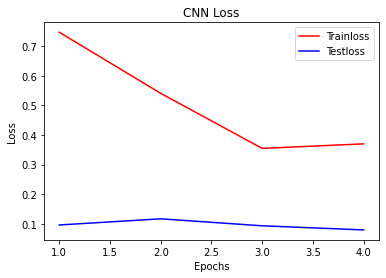

In [9]:
#Visualization

test_lost_array = Tensor(test_loss_array)
train_loss_array = Tensor(train_loss_array)

plt.plot(range(1,epochs),train_loss_array[1:], label='Trainloss', color = 'red')
plt.plot(range(1,epochs),test_loss_array[1:], label='Testloss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Loss')

#JULIA

# using Plots; default(fmt = :png)
# println("The snapshot logs - LeNet - has size = ",size(lenet_res))
# println("Final accuracy on test set = ",accuracy(lenet;data=dtst))

# trnloss,tstloss = Array{Float32}(lenet_res[1,:]), Array{Float32}(lenet_res[2,:]) 
# plot([trnloss,tstloss],labels=["trnloss" "tstloss"],xlabel="Epochs",ylabel="Loss")

Compare CNN to MLP and note the following
* There is no difference between the class of functions representable with an MLP vs CNN.
* CNNs converge faster and have better generalization capability
* CNNs are specifically good for data represented on graph structures, such as images (where the grid is the graph)
* Better find a GPU for CNNs